In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

In [2]:
#con = sqlite3.connect("./database.sqlite")
#cursor = con.cursor()
#cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [3]:
# close database
#cur.close()
#con.close()


In [4]:
#Imports
match_clean_player_4 = pd.read_csv('match_clean_player_4.csv')
#country_raw = pd.read_sql_query("SELECT * FROM Country", con)
#country = country_raw.copy()
#league_raw = pd.read_sql_query("SELECT * FROM League", con)
#league = league_raw.copy()
#player_raw = pd.read_sql_query("SELECT * FROM Player", con)#pd.read_csv('Player.csv', error_bad_lines=False)
#player = player_raw.copy()
player_att_clean = pd.read_csv("player_att_clean.csv")
#team_raw = pd.read_sql_query("SELECT * FROM Team", con)
#team = team_raw.copy()
team_att_clean = pd.read_csv("team_att_clean.csv")

In [5]:
# Attributing a shorter and easiest variable name to Exploratory Data Analysis
df = match_clean_player_4.copy()
print(df.shape)
df.head(5)

(542280, 20)


,country_id,country,league,season,stage,date,match_year,match_api_id,team_flag,team_api_id,team_long_name,team_short_name,team_goals,result,points,player_api_id,player_name,birthday,height,weight
0,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,30823,Stephane Grichting,1979-03-30,185.42,176
1,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,30977,Dariusz Dudka,1983-12-09,182.88,185
2,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,34037,Ireneusz Jelen,1981-04-09,182.88,163
3,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,40714,Remy Riou,1987-08-06,187.96,179
4,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,11323,Cedric Hengbart,1980-07-13,182.88,161


### Preliminar plot

The idea at first was to see if there was a positive correlation between team performance (measured in number of points earned per game: 3 if the team won, 1 if there was a draw and 0 if they lost) and mean player quality of the team (measured by their overall rating, included in the FIFA videogame attributes). Since both team perdormance and player rating are time-dependent, one would in principle have to consider a finite period of time (say, a season) for any meaningful pattern to show up.

So we set to get the said quantities for a given season. For that, one needs to go to the cleaned matches table and retrieve the points earned by each team at each match and the player id's of each ...

Fracton of missing players for this season and league 0.09206678266020064


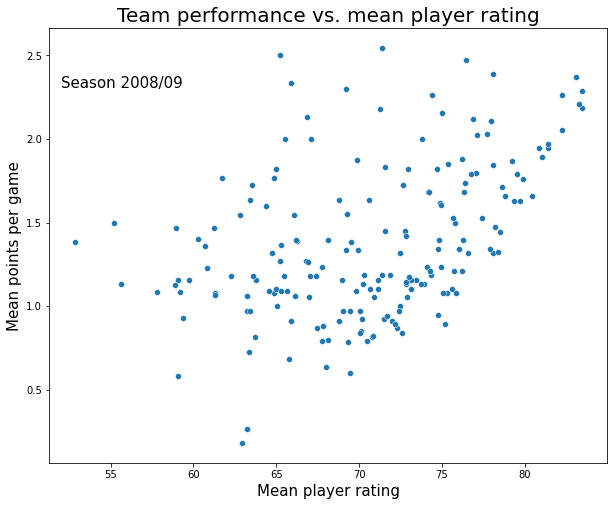

In [25]:
import seaborn as sns

playatts_alltime = player_att_clean.groupby(by=["player_api_id"]).mean()
genfont = 15
titfont = 20

seasons = np.unique(df["season"])

season_matches = df[df["season"] == seasons[0]]
#season_matches = season_matches[season_matches["league"] == "LIGA BBVA"]
start_date = "2008-09-01"; end_date = "2009-09-01"

team_points = season_matches.groupby(by=["match_api_id","team_api_id"]).mean()
team_points = team_points.groupby(by=["team_api_id"]).mean()

playatts_season = player_att_clean[player_att_clean["date"]>start_date]
playatts_season = playatts_season[playatts_season["date"]<end_date]
playatts_season = playatts_season.groupby(by=["player_api_id"]).mean()

pts_vs_rating = []
matches = np.unique(season_matches["match_api_id"])
missing_players_season = 0; total_players_season = 0
for match in matches:
    match_df = season_matches[season_matches["match_api_id"] == match]
    #print(match)
    teams = np.unique(match_df["team_api_id"])
    #print(teams)
    for team in teams:
        team_df = match_df[match_df["team_api_id"] == team]
        mean_team_rating = 0; count = 0
        for player in np.unique(team_df["player_api_id"]):
            total_players_season += 1
            try:
                mean_team_rating += playatts_season["overall_rating"][player]
                count += 1
                #print("player found!")
            except:
                try:
                    mean_team_rating += playatts_alltime["overall_rating"][player]
                    count += 1
                    #print ("player found only in all time table")
                except:
                    missing_players_season += 1
                    #print("player not found in player_att_clean")
        # there are some teams for which none of the players can be found
        if count != 0:
            mean_team_rating = mean_team_rating/count
            point = [team, mean_team_rating, team_points["points"][team]]
            pts_vs_rating.append(point)
print("Fracton of missing players for this season and league", 
      missing_players_season/total_players_season)
#pts_vs_rating

#PLOTTING
points_vs_rating = pd.DataFrame(pts_vs_rating, columns=["team_api_id", "mean_player_rating",
                                                       "points_per_game"])
# average over team duplicates
points_vs_rating = points_vs_rating.groupby(by="team_api_id").mean()
plt.figure(figsize = (10,8))
p1 = sns.scatterplot(data=points_vs_rating, x="mean_player_rating", y="points_per_game",
                palette="BuGn")
#p2 = sns.scatterplot(data=points_vs_rating.iloc[:15,:], x="mean_player_rating", y="points_per_game",
 #               palette="BuGn", color="red", size=1000*np.ones((15)))
plt.xlabel("Mean player rating", fontsize=genfont)
plt.ylabel("Mean points per game", fontsize=genfont)
plt.title("Team performance vs. mean player rating", fontsize=titfont)
p1.text(52,2.2, "Season 2008/09\n", fontsize=genfont)

plt.show()
            

### Serious plots

The tables for every season and league are stored in
"data/"+str(season[:4])+"-"+"".join(league.split())+".csv" ,
where "season[:4]" is the first year of the season ("2008" for 2008/2009) and "league" is one of the leagues listed below.

In [6]:
np.unique(df["league"])

array(['1. Bundesliga', 'Ekstraklasa', 'Eredivisie', 'Jupiler League',
       'LIGA BBVA', 'Liga ZON Sagres', 'Ligue 1', 'Premier League',
       'Scottish Premiership', 'Serie A', 'Super League'], dtype=object)

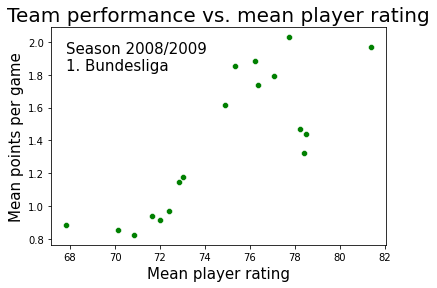

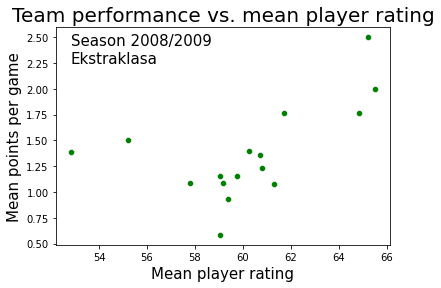

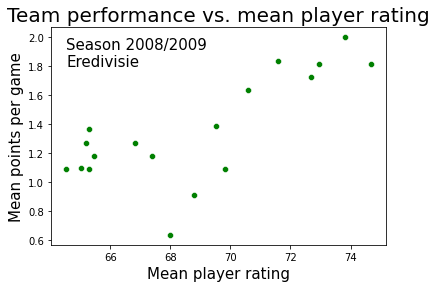

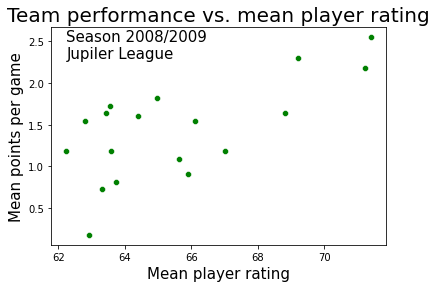

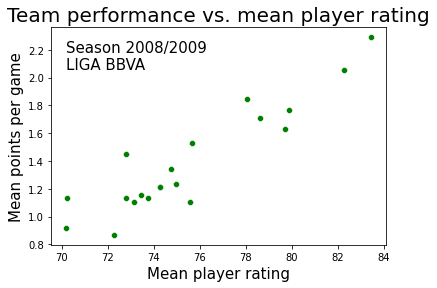

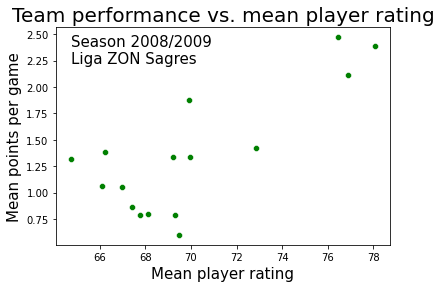

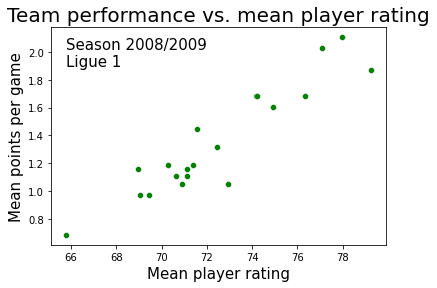

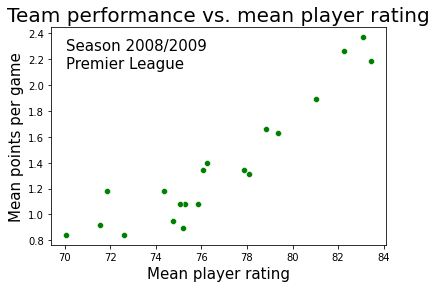

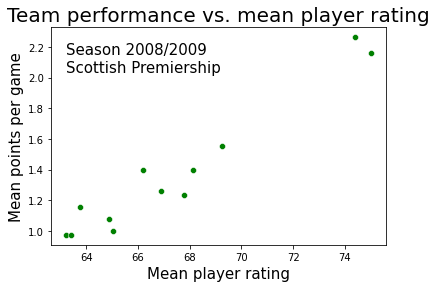

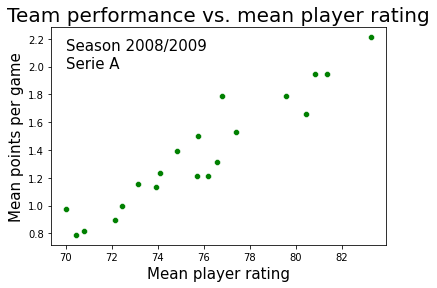

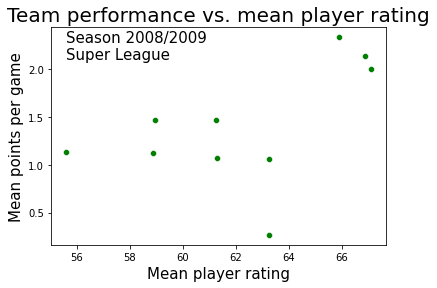

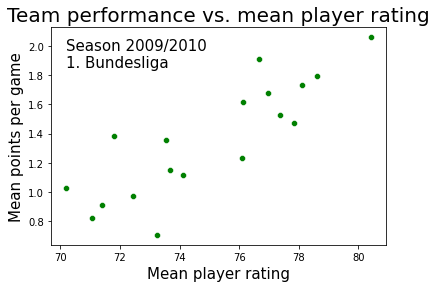

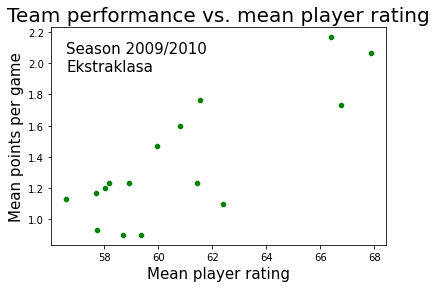

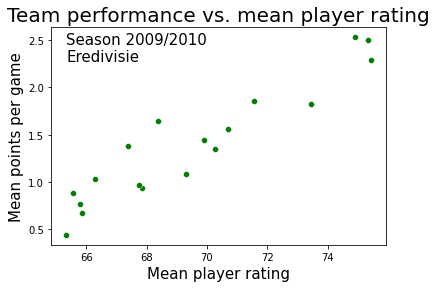

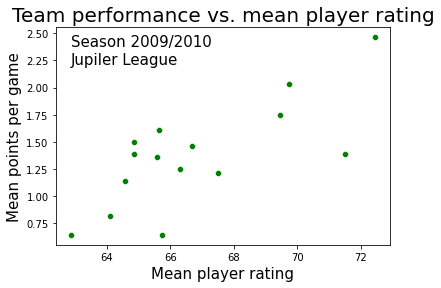

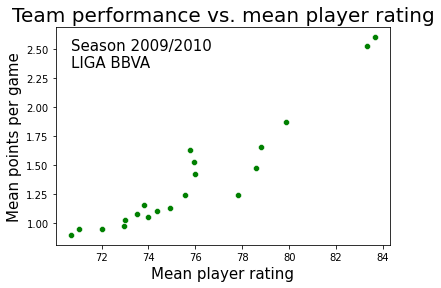

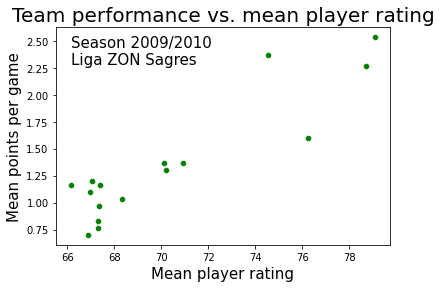

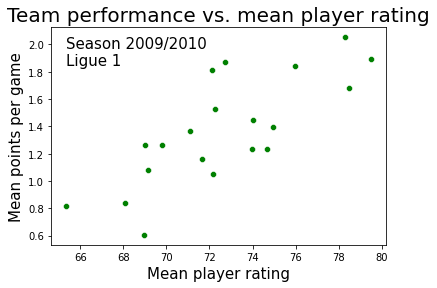

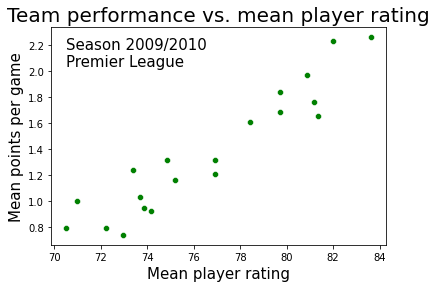

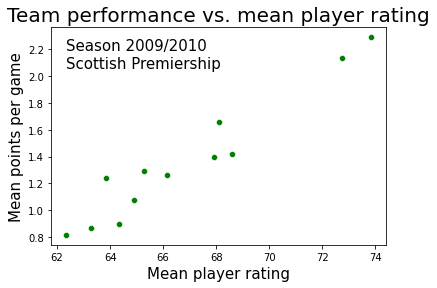

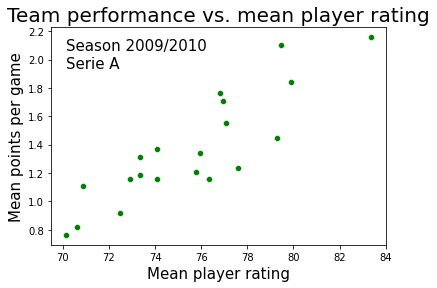

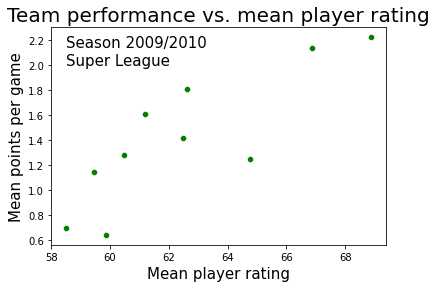

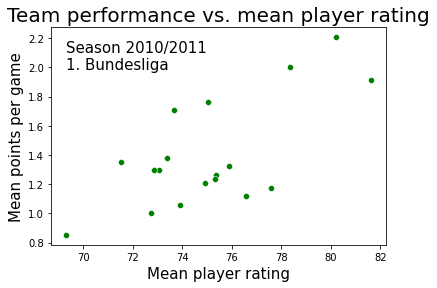

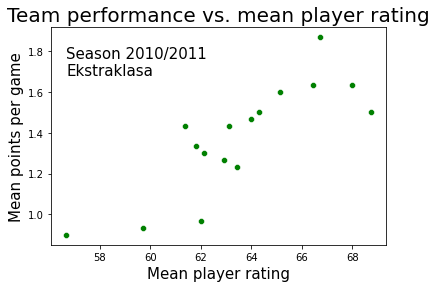

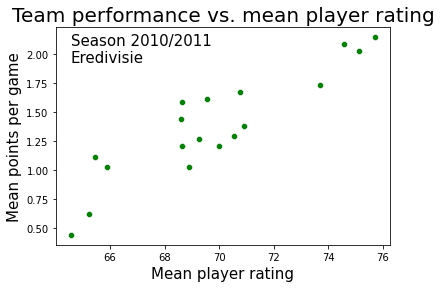

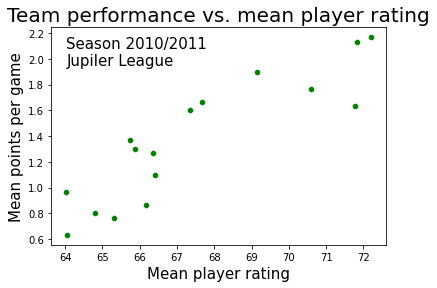

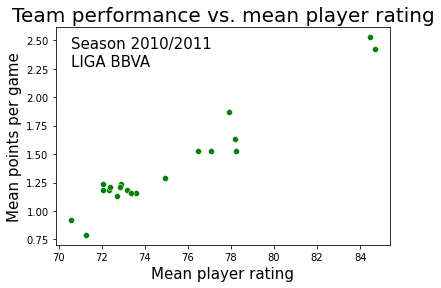

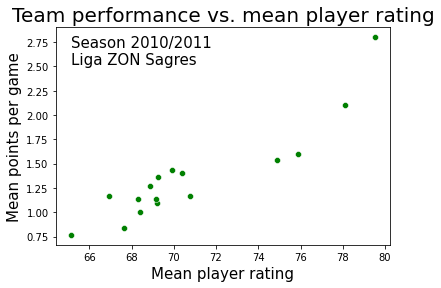

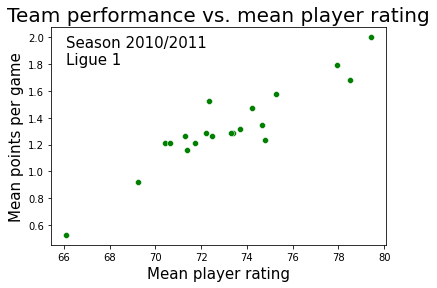

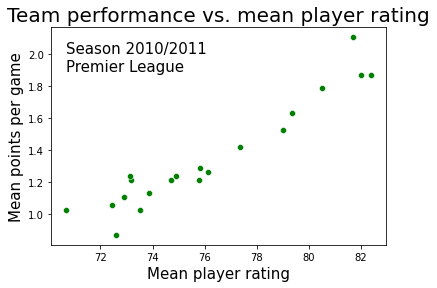

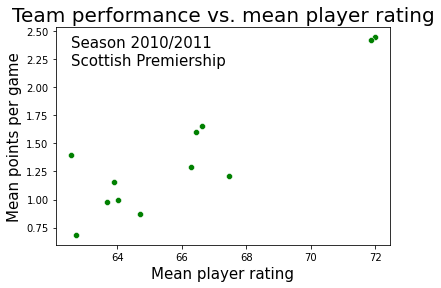

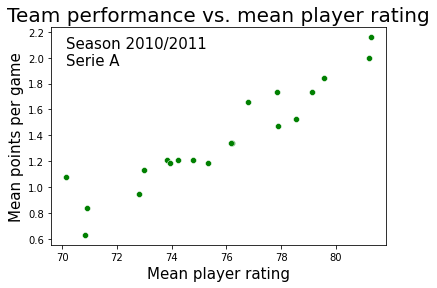

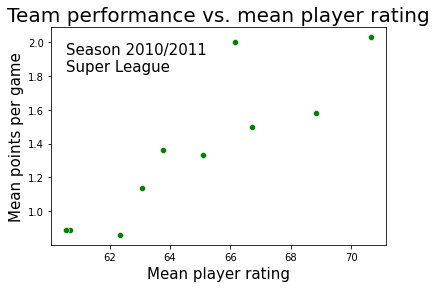

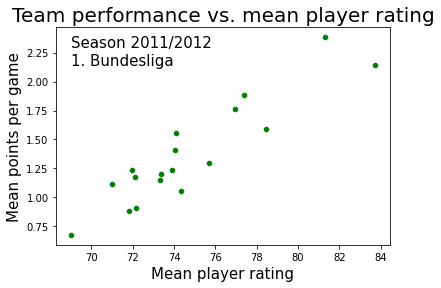

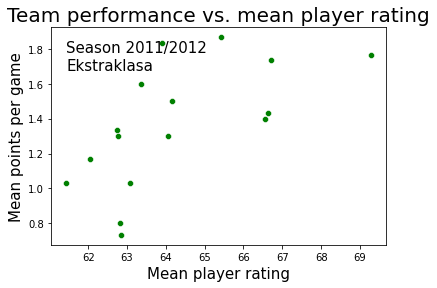

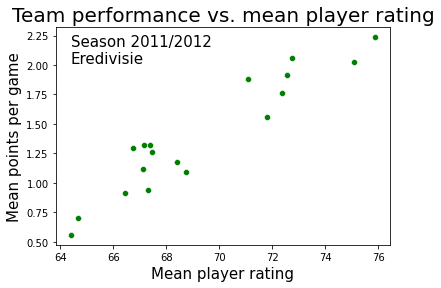

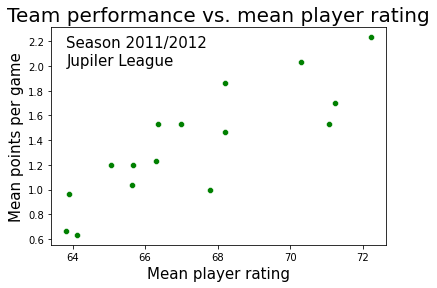

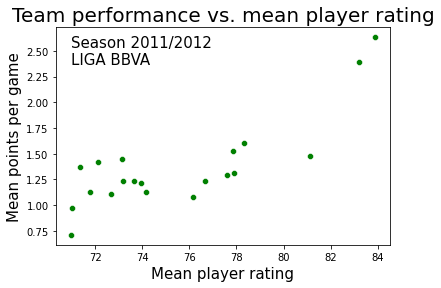

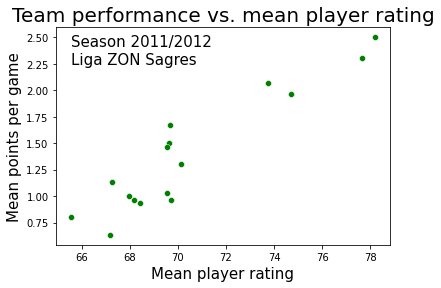

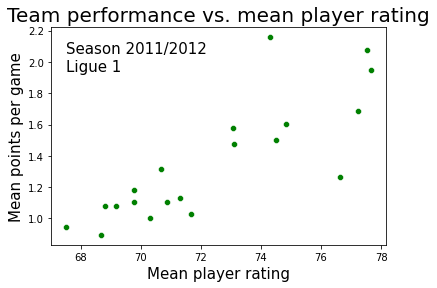

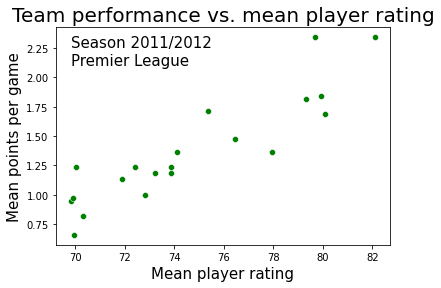

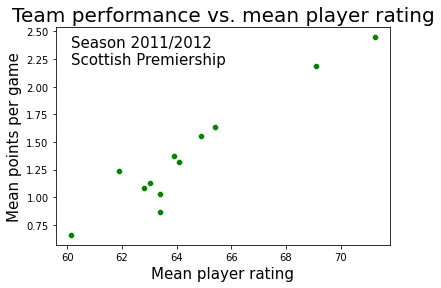

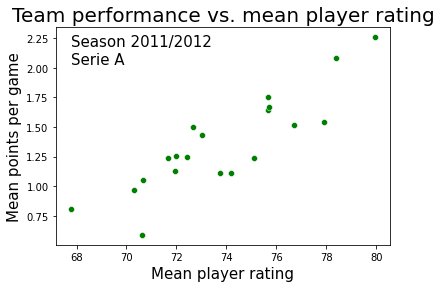

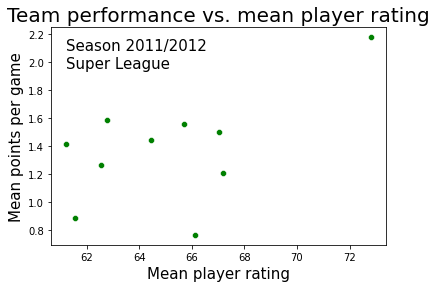

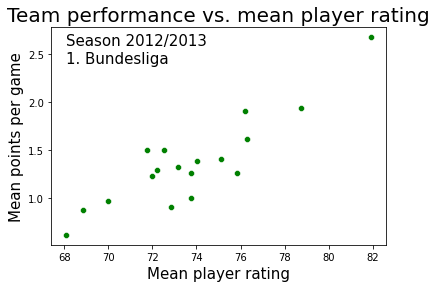

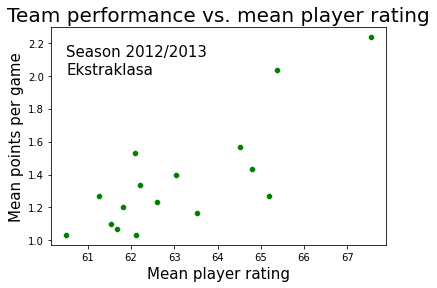

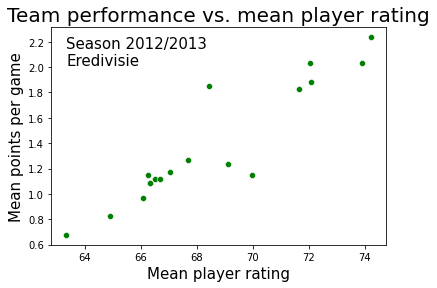

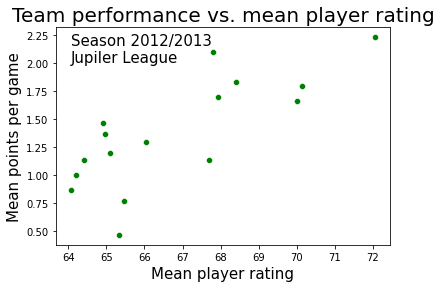

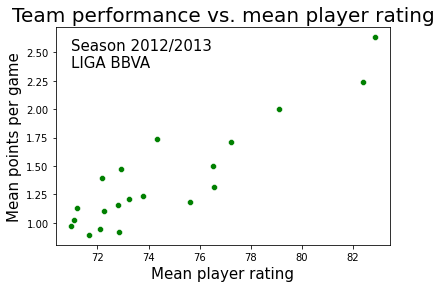

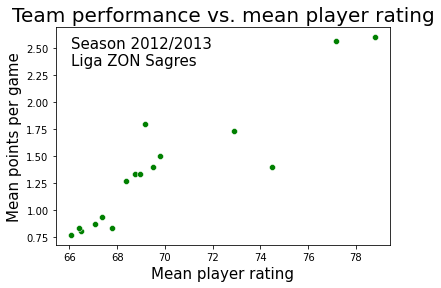

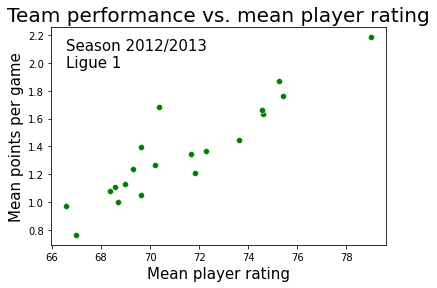

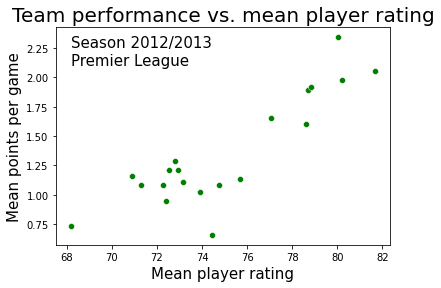

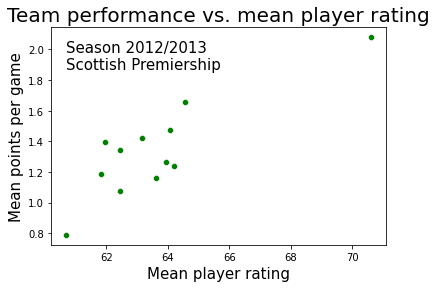

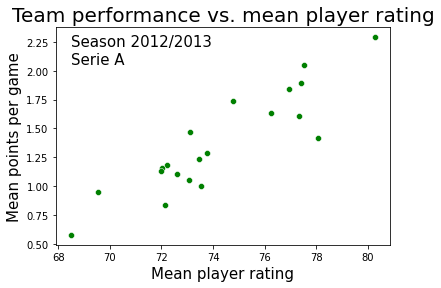

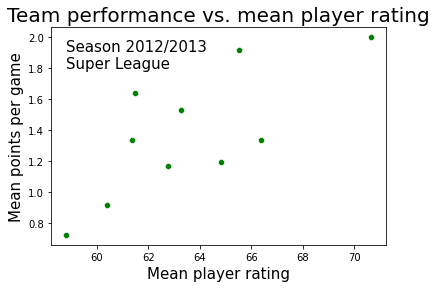

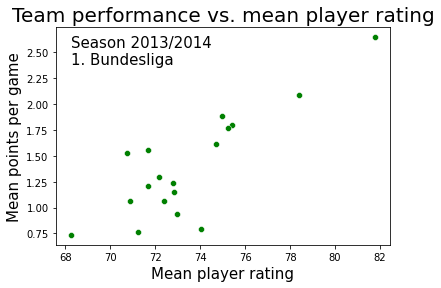

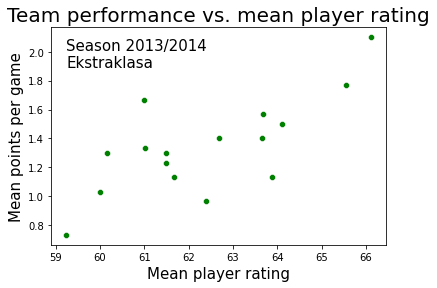

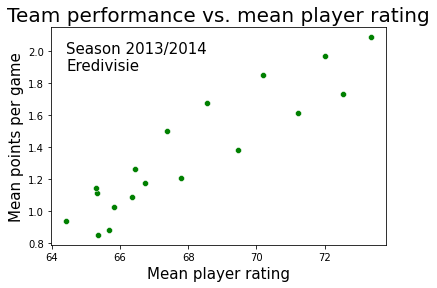

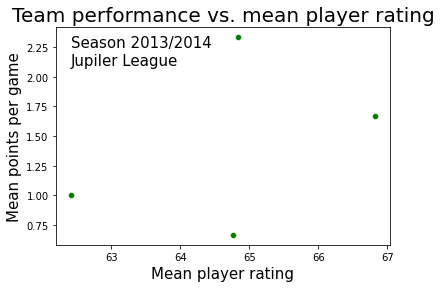

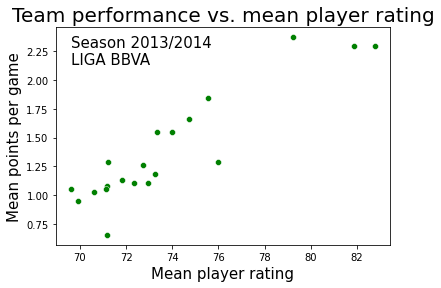

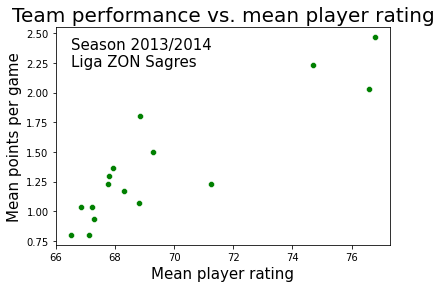

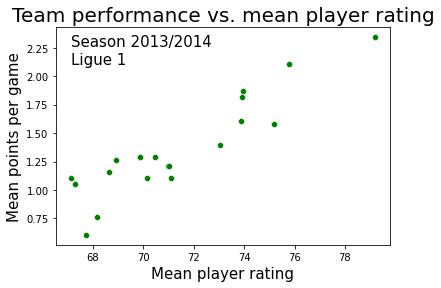

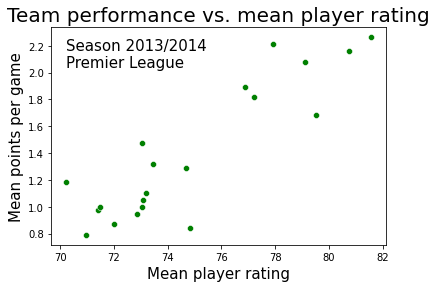

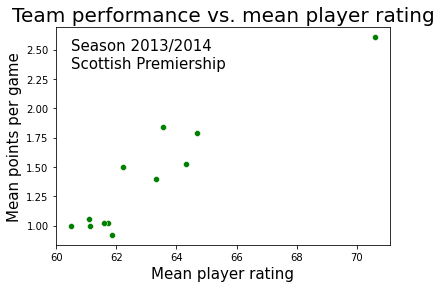

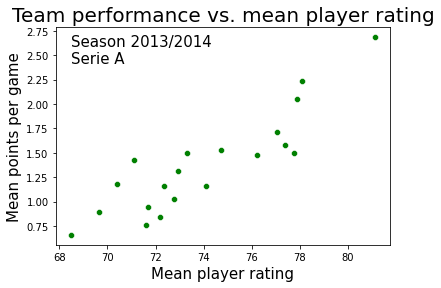

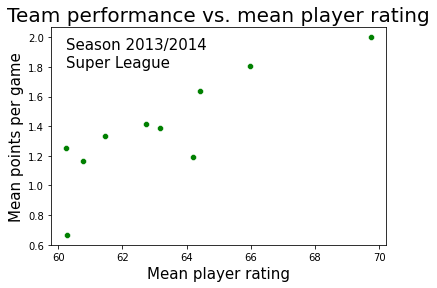

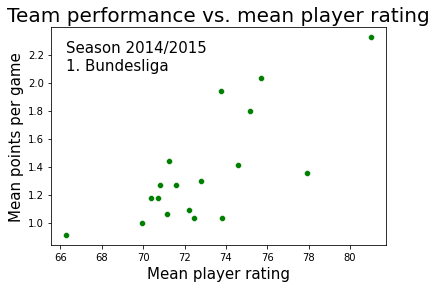

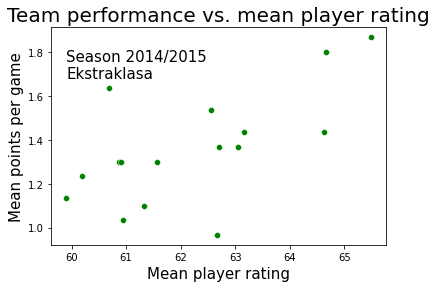

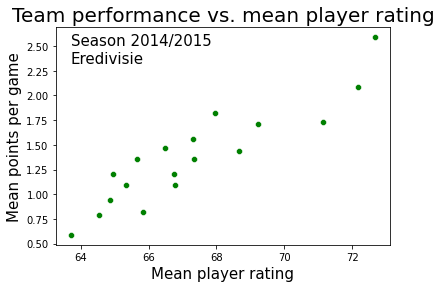

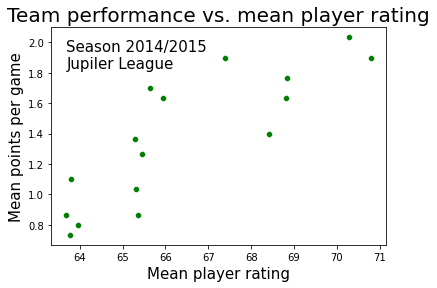

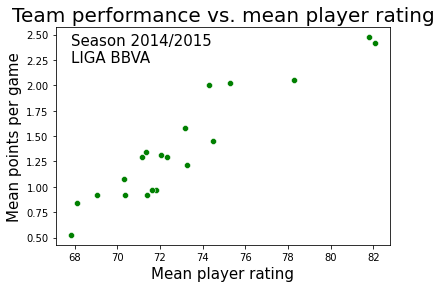

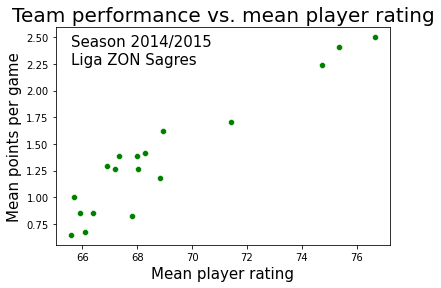

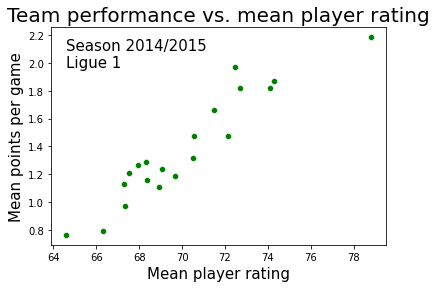

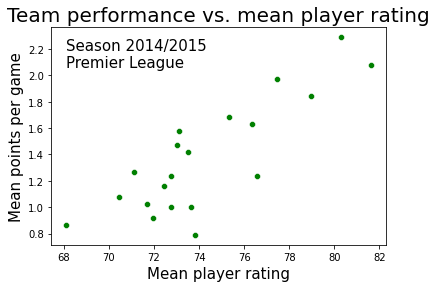

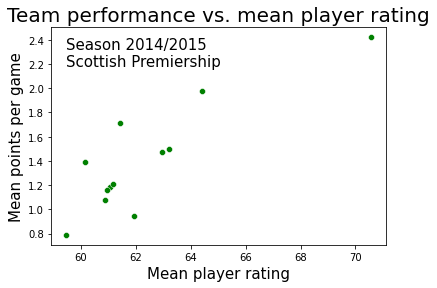

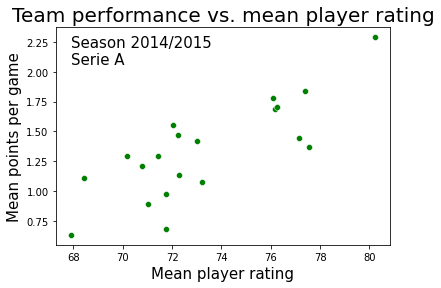

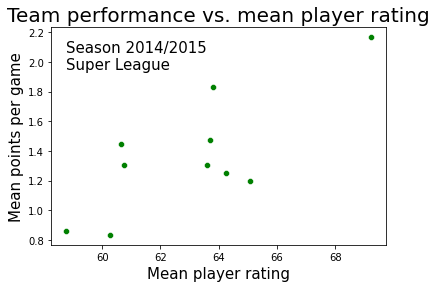

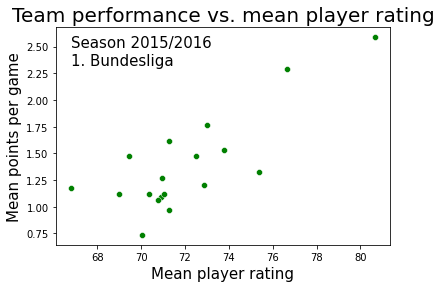

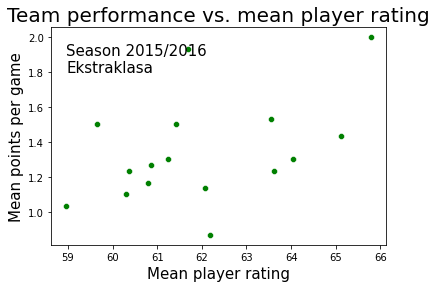

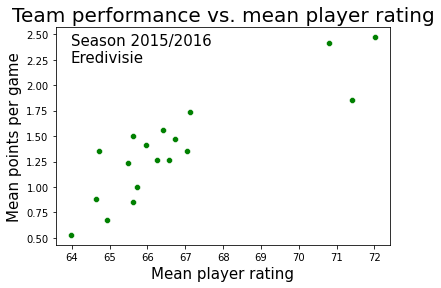

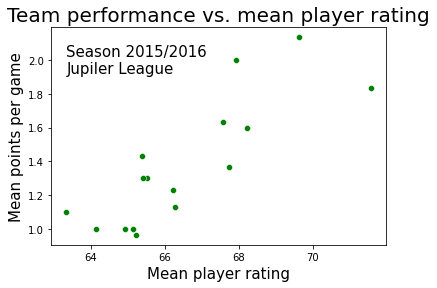

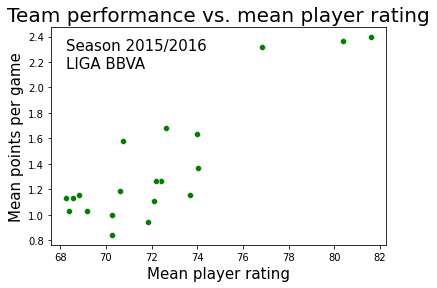

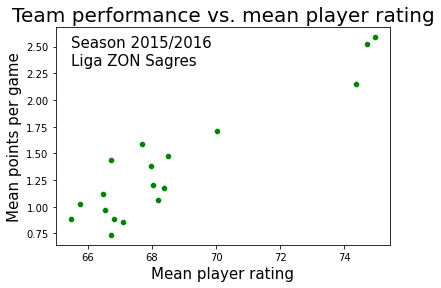

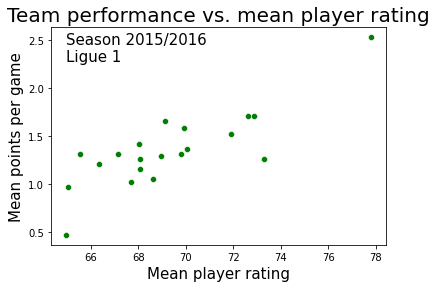

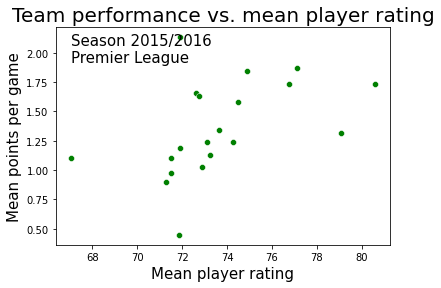

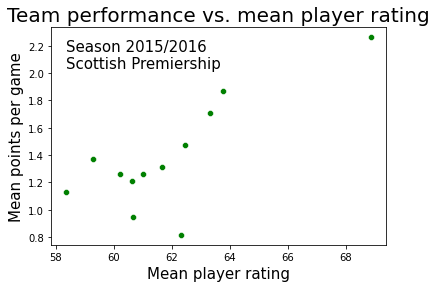

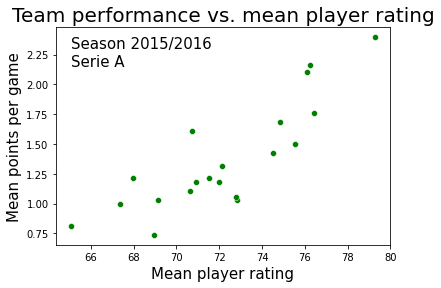

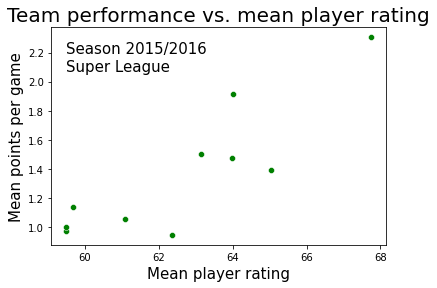

Number of missing players over all seasons and leagues:
 650
Number of all players in player_att_clean:
 10410


In [17]:
#import seaborn as sns

playatts_alltime = player_att_clean.groupby(by=["player_api_id"]).mean()
genfont = 15
titfont = 20

seasons = np.unique(df["season"])
leagues = np.unique(df["league"])
start_date = "2008-09-01"; end_date = "2009-09-01"; addyears = 0
missing_players = []

for season in seasons:
    start_date = str(int(start_date[:4])+addyears)+"-09-01"
    end_date = str(int(end_date[:4])+addyears)+"-09-01"
    addyears += 1
    season_matches = df[df["season"] == season]
    
    for league in leagues:
        league_matches = season_matches[season_matches["league"] == league]
        if league_matches.empty:
            print("No matches for league", league, "in season", season,
                  ". Skipping the league for this season...")
            continue
        team_points = league_matches.groupby(by=["match_api_id","team_api_id"]).mean()
        team_points = team_points.groupby(by=["team_api_id"]).mean()

        playatts_season = player_att_clean[player_att_clean["date"]>start_date]
        playatts_season = playatts_season[playatts_season["date"]<end_date]
        playatts_season = playatts_season.groupby(by=["player_api_id"]).mean()
        #print("playatts empty? ",playatts_season.empty)
        
        pts_vs_rating = []
        matches = np.unique(league_matches["match_api_id"])
        for match in matches:
            match_df = league_matches[league_matches["match_api_id"] == match]
            teams = np.unique(match_df["team_api_id"])
            for team in teams:
                team_df = match_df[match_df["team_api_id"] == team]
                mean_team_rating = 0; count = 0
                for player in np.unique(team_df["player_api_id"]):
                    try:
                        mean_team_rating += playatts_season["overall_rating"][player]
                        count += 1
                        #print("player found!")
                    except:
                        try:
                            mean_team_rating += playatts_alltime["overall_rating"][player]
                            count += 1
                            #print ("player found only in all time table")
                        except:
                            missing_players.append(player)
                            #print("player not found in player_att_clean")
                # there are some teams for which none of the players can be found
                if count > 0:
                    mean_team_rating = mean_team_rating/count
                    point = [team, mean_team_rating, team_points["points"][team]]
                    pts_vs_rating.append(point)
        #pts_vs_rating

        #define dataframe with resulting table for export and plot
        points_vs_rating = pd.DataFrame(pts_vs_rating, columns=["team_api_id", 
                                                                "mean_player_rating",
                                                               "points_per_game"])
        # average over team duplicates
        points_vs_rating = points_vs_rating.groupby(by="team_api_id").mean()
        
        points_vs_rating.to_csv("data/"+str(season[:4])+"-"+"".join(league.split())+".csv")
        p1 = sns.scatterplot(data=points_vs_rating, x="mean_player_rating", y="points_per_game",
                        palette="BuGn", color="green")
        #p2 = sns.scatterplot(data=points_vs_rating.iloc[:15,:], x="mean_player_rating", 
        #y="points_per_game", palette="BuGn", color="red", size=1000*np.ones((15)))
        min_x = min(points_vs_rating["mean_player_rating"])
        max_y = max(points_vs_rating["points_per_game"])
        plt.xlabel("Mean player rating", fontsize=genfont)
        plt.ylabel("Mean points per game", fontsize=genfont)
        plt.title("Team performance vs. mean player rating", fontsize=titfont)
        p1.text(min_x*1, max_y*0.9, "Season "+str(season)+"\n"+str(league), fontsize=genfont)
        plt.show()
print ("Number of missing players over all seasons and leagues:\n",
       len(np.unique(missing_players)))
print ("Number of all players in player_att_clean:\n",
       len(np.unique(player_att_clean["player_api_id"])))


            